In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency, ttest_ind, zscore
from sklearn.feature_selection import f_classif

In [2]:
# Load the data
data = pd.read_csv('healthcare_dataset.csv', delimiter=',', encoding='ISO-8859-1')
data = data.drop(columns=['Name', 'Doctor'])

In [3]:
# Create new feature: Length of Stay
data['Date of Admission'] = pd.to_datetime(data['Date of Admission'])
data['Discharge Date'] = pd.to_datetime(data['Discharge Date'])
data['Length of Stay'] = (data['Discharge Date'] - data['Date of Admission']).dt.days
data = data.drop(['Date of Admission', 'Discharge Date', 'Hospital', 'Room Number'], axis=1)

In [4]:
# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le


scaler = StandardScaler()
data['Billing Amount'] = scaler.fit_transform(data[['Billing Amount']])


print(data.head())

   Age  Gender  Blood Type  Medical Condition  Insurance Provider  \
0   30       1           5                  2                   1   
1   62       1           0                  5                   3   
2   76       0           1                  5                   0   
3   28       0           6                  3                   3   
4   43       0           2                  2                   0   

   Billing Amount  Admission Type  Medication  Test Results  Length of Stay  
0       -0.470261               2           3             2               2  
1        0.570250               1           1             1               6  
2        0.169990               1           0             2              15  
3        0.870465               0           1             0              30  
4       -0.795211               2           4             0              20  


In [5]:
# Calculate variance for numerical features
variances = data.drop(columns=['Age']).var()
print(variances)


Gender                 0.250004
Blood Type             5.242724
Medical Condition      2.918412
Insurance Provider     1.988507
Billing Amount         1.000018
Admission Type         0.670839
Medication             1.997257
Test Results           0.669269
Length of Stay        74.988675
dtype: float64


In [6]:
# Identify outliers using Z-score
z_scores = stats.zscore(data.select_dtypes(include=['number']))
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data_no_outliers = data[filtered_entries]

# Check the shape of the data
print(data.shape)
print(data_no_outliers.shape)

(55500, 10)
(55500, 10)


In [7]:
filtered_entries

0        True
1        True
2        True
3        True
4        True
         ... 
55495    True
55496    True
55497    True
55498    True
55499    True
Length: 55500, dtype: bool

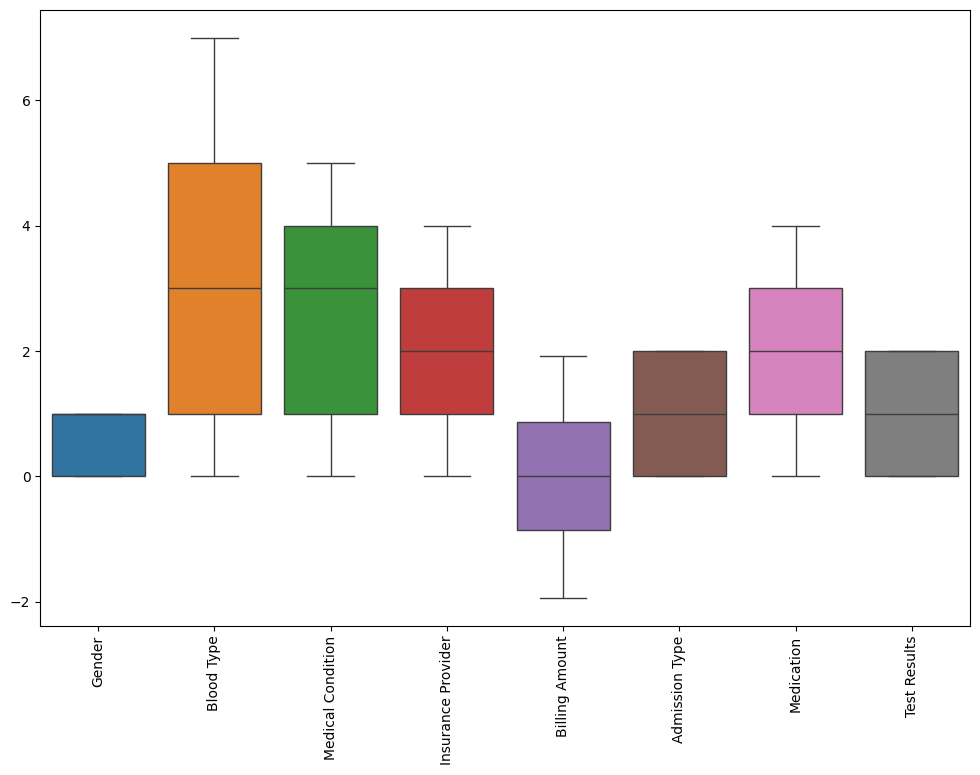

In [8]:
# Boxplot for numerical features 
plt.figure(figsize=(12, 8))
sns.boxplot(data=data_no_outliers.drop(columns=['Age', 'Length of Stay']).select_dtypes(include=['number']))
plt.xticks(rotation=90)
plt.show()

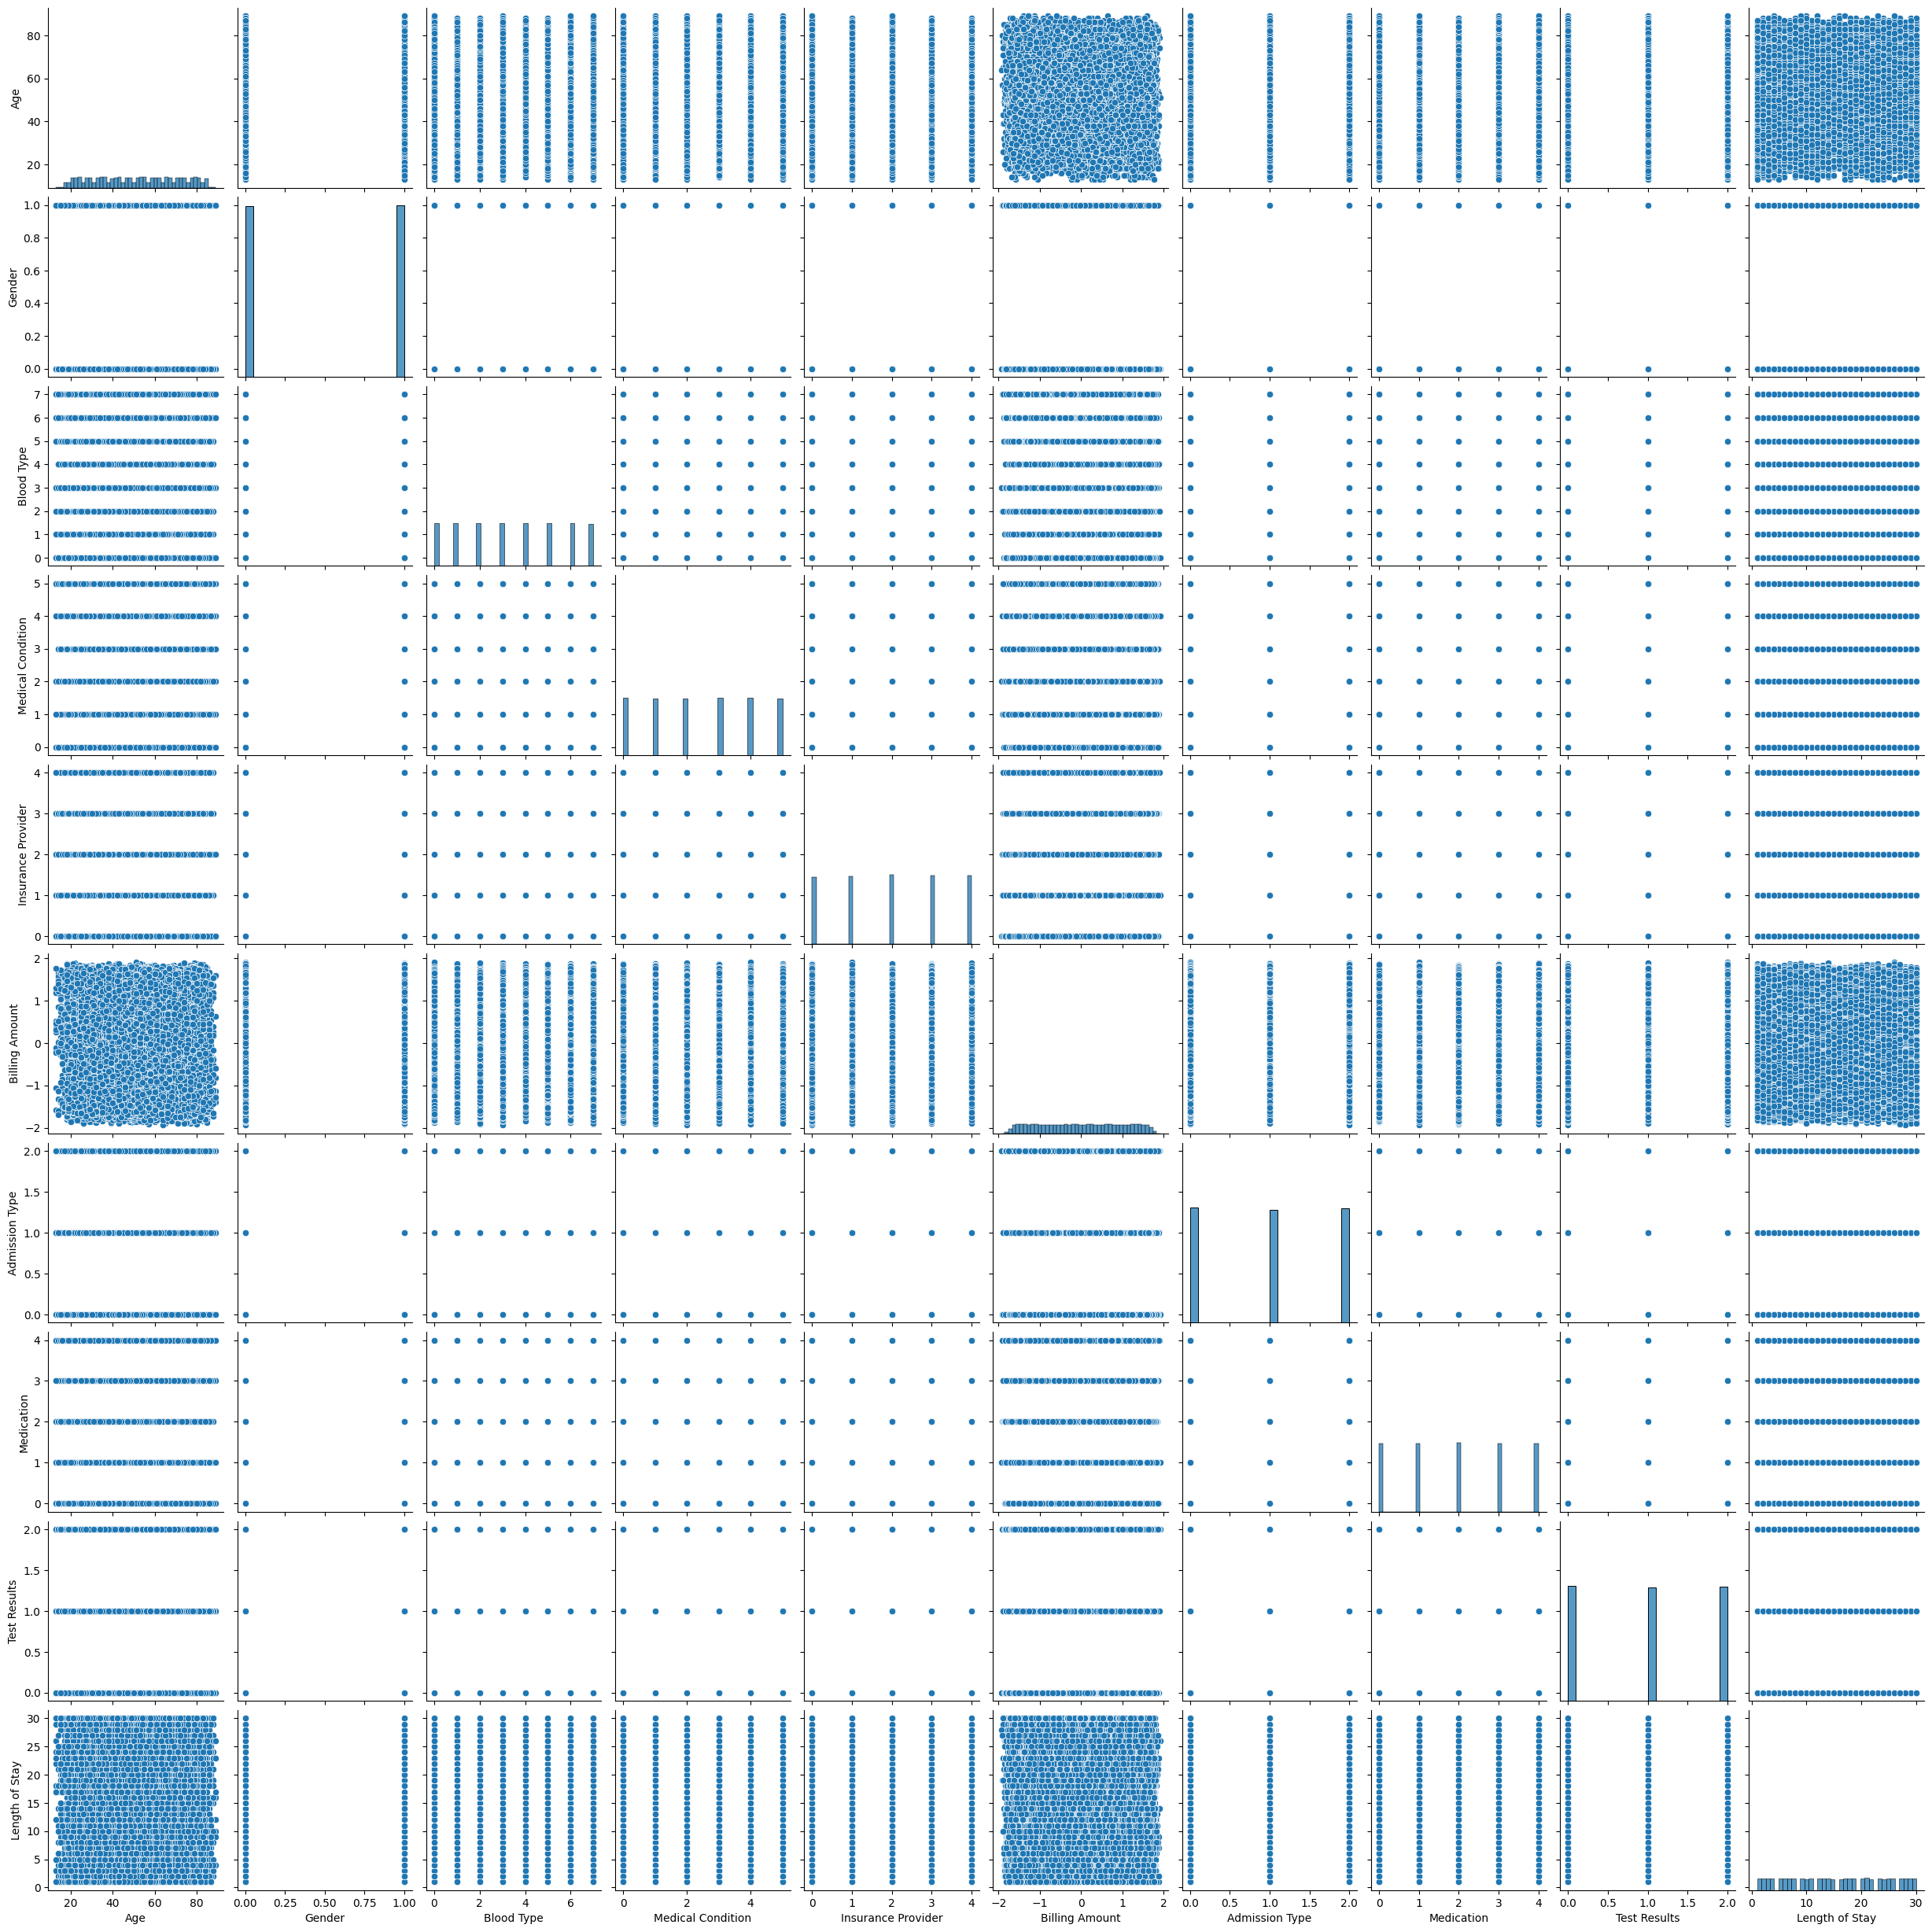

In [9]:
# Pairplot
sns.pairplot(data_no_outliers)
plt.show()

              Feature  Importance
5      Billing Amount    0.247205
0                 Age    0.186016
8      Length of Stay    0.159856
2          Blood Type    0.094655
3   Medical Condition    0.081905
7          Medication    0.075225
4  Insurance Provider    0.074553
6      Admission Type    0.050179
1              Gender    0.030406


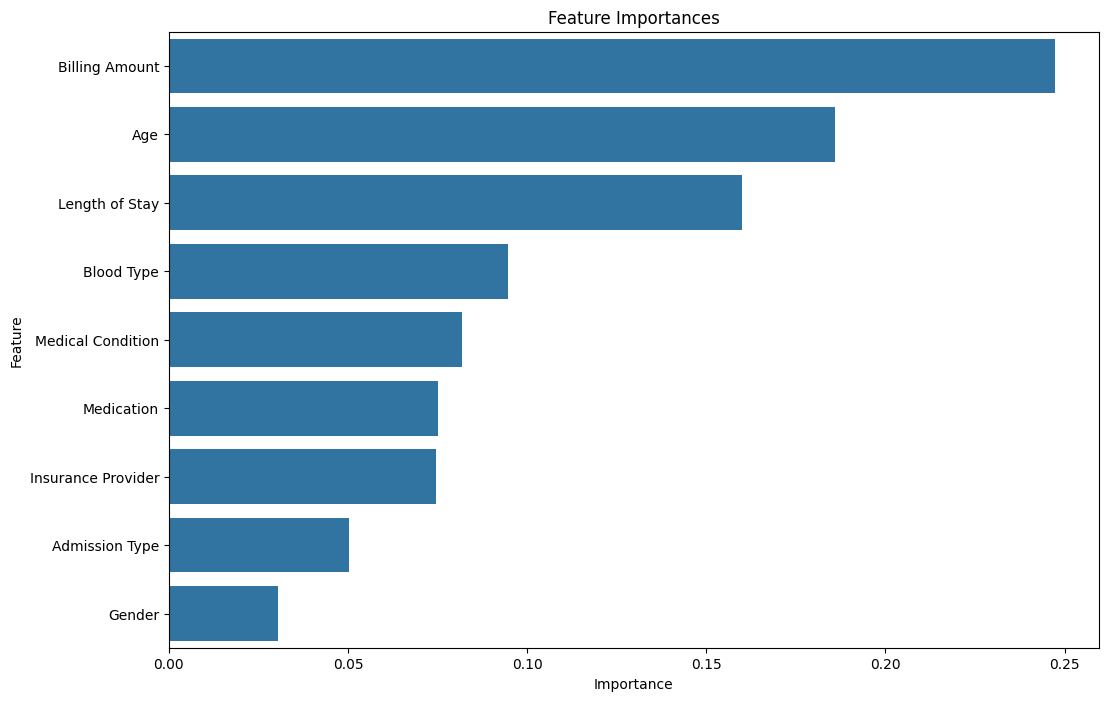

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare data for classification
X = data.drop(columns=['Test Results'])
y = data['Test Results']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display feature importances
print(importance_df)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()


In [11]:
# Make predictions and evaluate the model
y_pred = rf_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.44027027027027027
              precision    recall  f1-score   support

           0       0.44      0.45      0.45      3754
           1       0.43      0.43      0.43      3617
           2       0.45      0.44      0.44      3729

    accuracy                           0.44     11100
   macro avg       0.44      0.44      0.44     11100
weighted avg       0.44      0.44      0.44     11100



In [12]:
# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

In [13]:
# Chi-Square Test
chi_square_results = {}
for col in data.columns:
    if col != 'Test Results':
        contingency_table = pd.crosstab(data[col], data['Test Results'])
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        chi_square_results[col] = {'chi2': chi2, 'p-value': p}

print("Chi-Square Test Results:")
chi_square_results

Chi-Square Test Results:


{'Age': {'chi2': 148.4989744913025, 'p-value': 0.5651495787325469},
 'Gender': {'chi2': 2.0183509473266747, 'p-value': 0.3645194115525123},
 'Blood Type': {'chi2': 7.631682910196957, 'p-value': 0.9076188241892073},
 'Medical Condition': {'chi2': 13.255075598058793,
  'p-value': 0.20975788848479074},
 'Insurance Provider': {'chi2': 8.37755432208288,
  'p-value': 0.39748477869918286},
 'Billing Amount': {'chi2': 110999.99999999997,
  'p-value': 4.933065266228394e-125},
 'Admission Type': {'chi2': 1.319805916838722, 'p-value': 0.8580063174351872},
 'Medication': {'chi2': 3.7311408909774406, 'p-value': 0.8805297989370955},
 'Length of Stay': {'chi2': 58.211581943347745, 'p-value': 0.4675017578482418}}

In [14]:
# Z-Score
z_scores = data.select_dtypes(include=['number']).apply(zscore)
print("Z-Scores:")
print(z_scores)

Z-Scores:
            Age    Gender  Blood Type  Medical Condition  Insurance Provider  \
0     -1.098824  0.999136    0.658348          -0.292010           -0.715785   
1      0.533639  0.999136   -1.525364           1.464101            0.702522   
2      1.247842 -1.000865   -1.088622           1.464101           -1.424939   
3     -1.200853 -1.000865    1.095090           0.293360            0.702522   
4     -0.435636 -1.000865   -0.651879          -0.292010           -1.424939   
...         ...       ...         ...                ...                 ...   
55495 -0.486651 -1.000865    1.095090          -0.877380           -0.715785   
55496  0.482625 -1.000865   -0.215137           1.464101           -0.006632   
55497 -0.690708 -1.000865    0.221605           0.878730            1.411676   
55498 -0.435636  0.999136    1.531833          -1.462751            0.702522   
55499  0.074509 -1.000865    1.095090          -1.462751           -1.424939   

       Billing Amount  Admiss

In [15]:
# ANOVA F-Test
X = data.drop(columns=['Test Results'])
y = data['Test Results']

f_values, p_values = f_classif(X, y)
anova_results = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'p-value': p_values})
anova_results = anova_results.sort_values(by='F-Value', ascending=False)

print("ANOVA F-Test Results:")
print(anova_results)


ANOVA F-Test Results:
              Feature   F-Value   p-value
4  Insurance Provider  3.084460  0.045763
0                 Age  1.849758  0.157285
1              Gender  1.009158  0.364533
5      Billing Amount  0.636811  0.528981
7          Medication  0.469190  0.625511
2          Blood Type  0.454885  0.634523
8      Length of Stay  0.379228  0.684391
6      Admission Type  0.338122  0.713110
3   Medical Condition  0.160248  0.851933


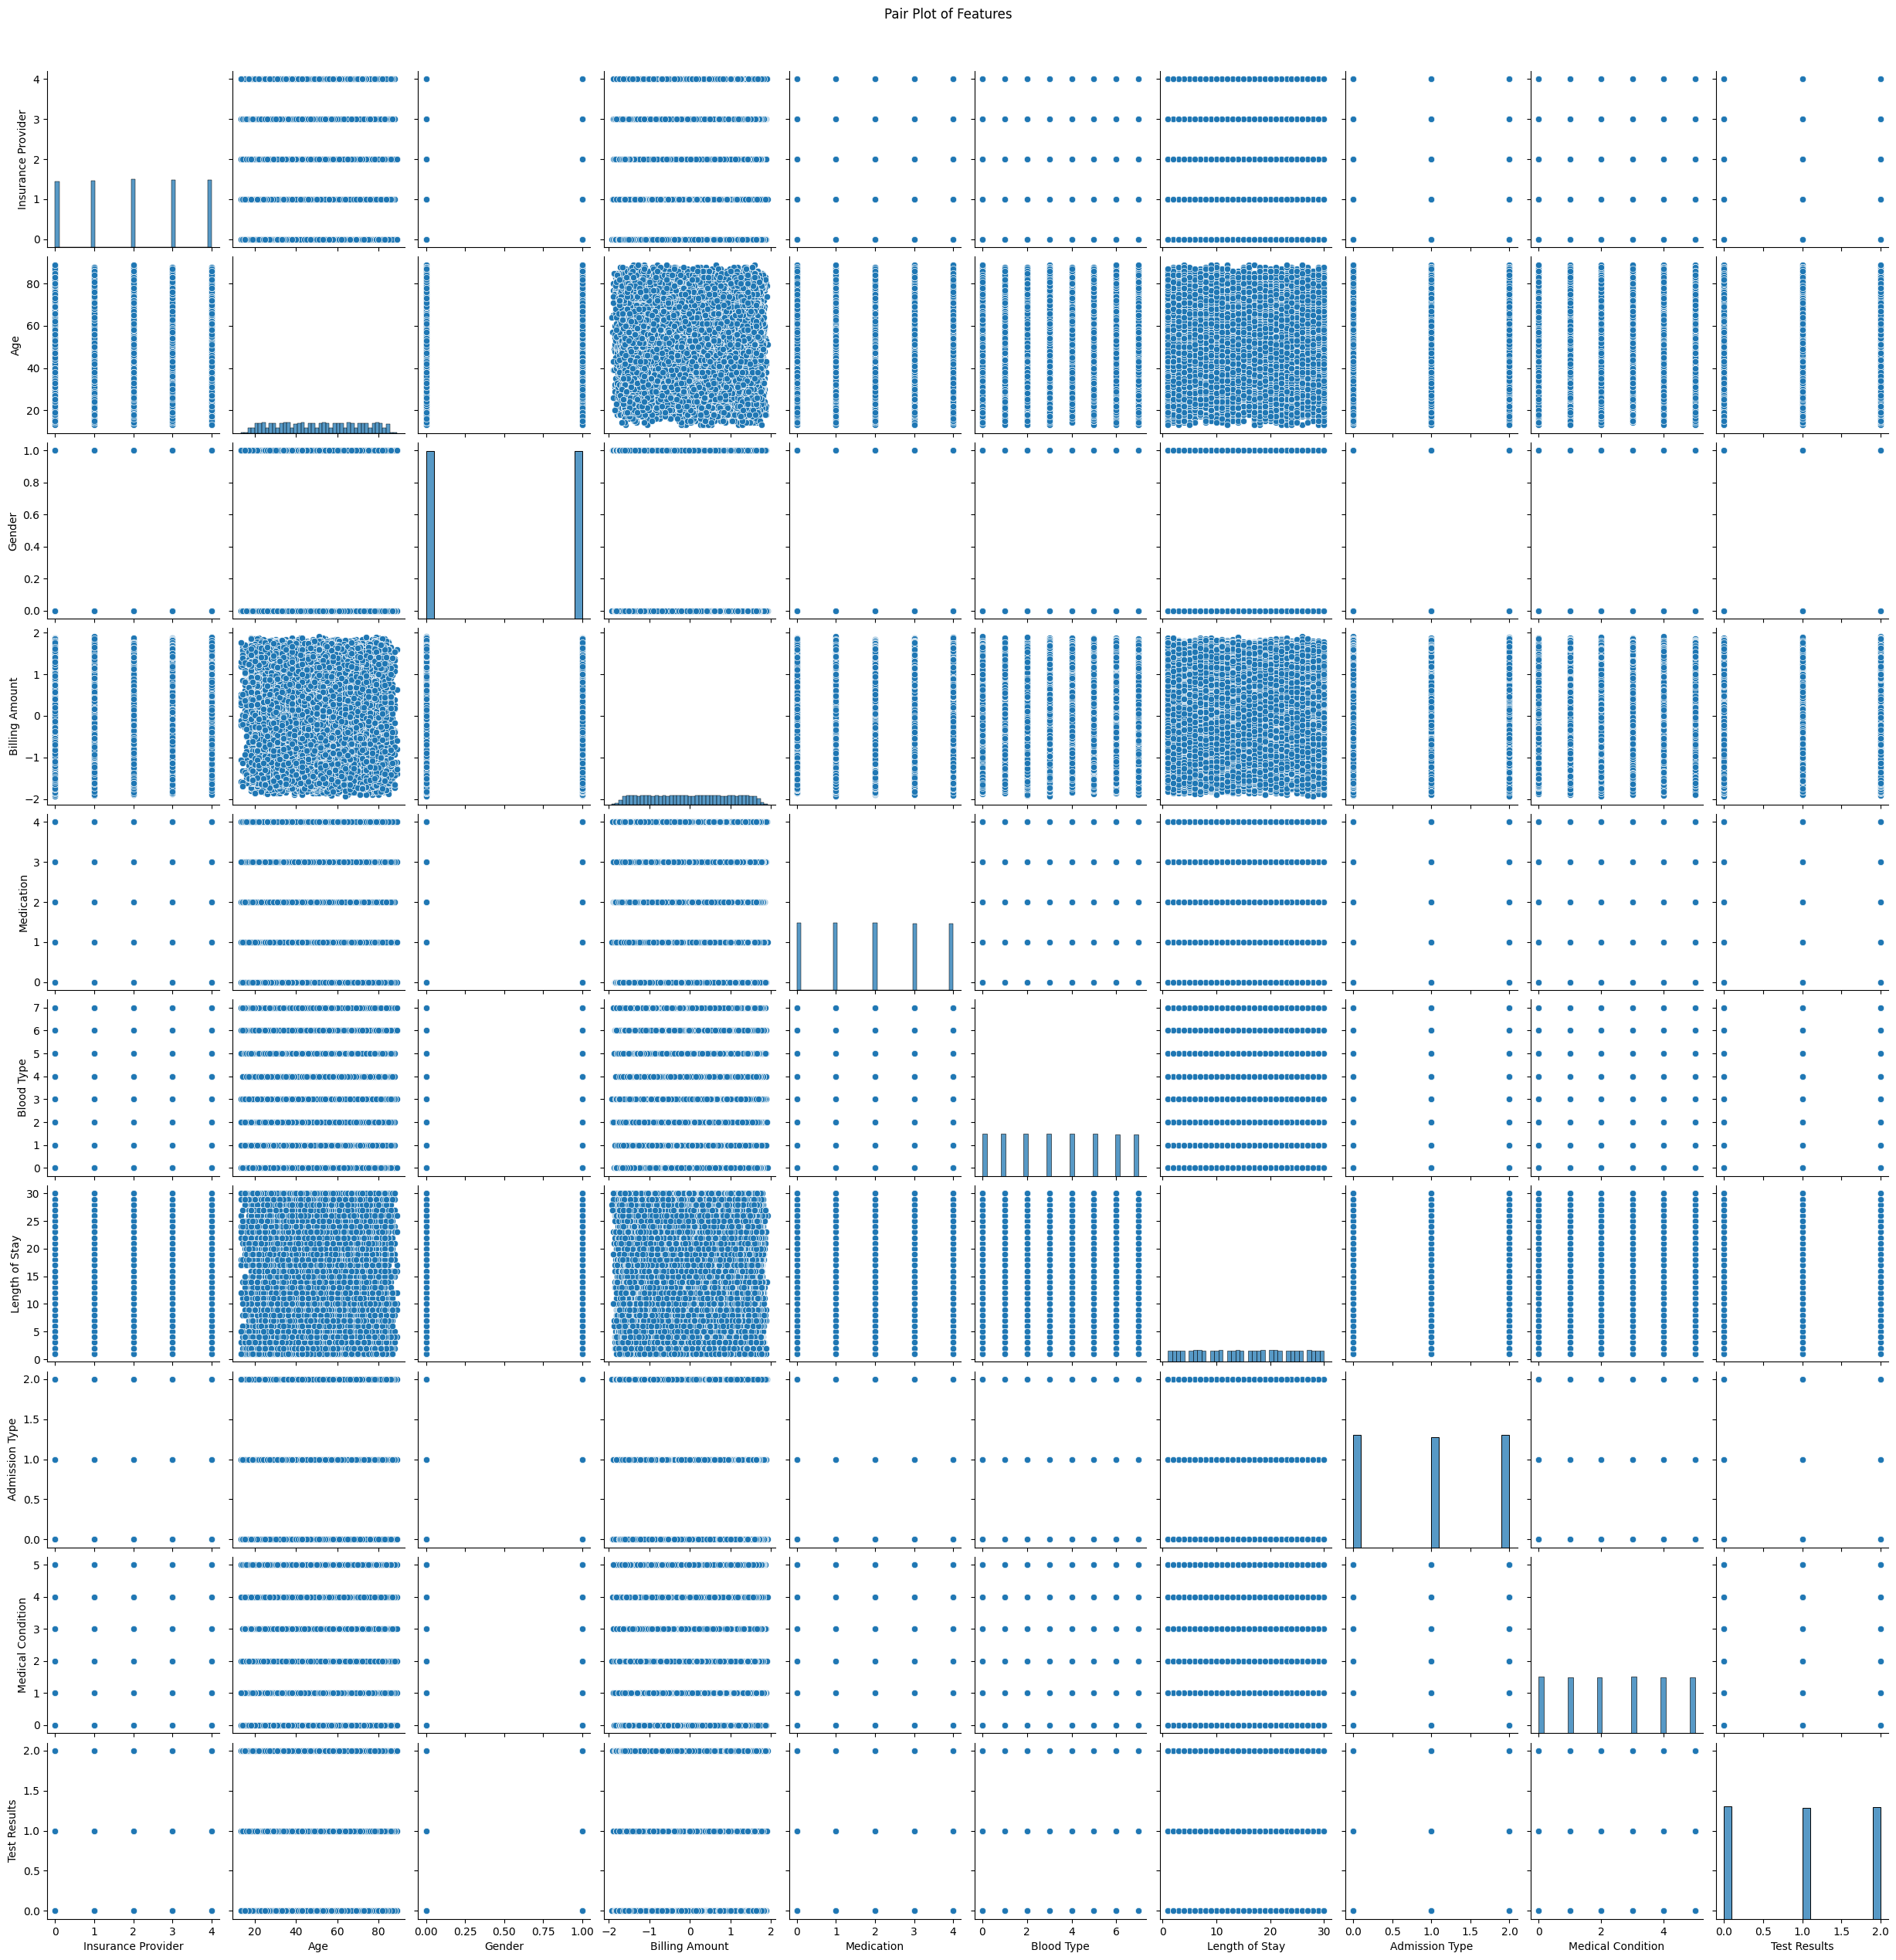

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame containing the features of interest
features_of_interest = ['Insurance Provider','Age','Gender','Billing Amount','Medication','Blood Type','Length of Stay','Admission Type','Medical Condition','Test Results']  # Specify which features you want to plot

sns.pairplot(data[features_of_interest])
plt.suptitle('Pair Plot of Features', y=1.02)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import chi2_contingency, ttest_ind, zscore
from sklearn.feature_selection import f_classif

# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Scale the Billing Amount
scaler = StandardScaler()
data['Billing Amount'] = scaler.fit_transform(data[['Billing Amount']])

# ANOVA F-Test
X = data.drop(columns=['Test Results'])
y = data['Test Results']

# Ensure that the target variable is correctly shaped
y = y.values.ravel()

# Perform ANOVA F-test
f_values, p_values = f_classif(X, y)
anova_results = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'p-value': p_values})
anova_results = anova_results.sort_values(by='F-Value', ascending=False)

print("ANOVA F-Test Results:")
print(anova_results)
